# Stack Overflow Survey 2018: Technology Preferences

In this notebook I'll create rankings of technologies, that respondents of the [Stack Overflow Survey 2018](https://insights.stackoverflow.com/survey/2018/) worked with in the past, want to work with in the future, where these overlap and where not. The survey asked 4 similar questions about languages, databases, platforms and frameworks, below is the one about languages:

> Which of the following programming, scripting, and markup languages have you done extensive development work in over the past year, and which do you want to work in over the next year?  (If you both worked with the language and want to continue to do so, please check both boxes in that row.)

## Setup

The code in the next cell imports the Python libraries that'll be used, sets display and style parameters, loads the data from the CSV file [made available on Kaggle](https://www.kaggle.com/stackoverflow/stack-overflow-2018-developer-survey) and outputs the first few rows.

In [1]:
%matplotlib inline

import os

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from collections import Counter
from itertools import chain
from matplotlib.ticker import FuncFormatter
from textwrap import shorten

pd.options.display.max_colwidth = 200
mpl.style.use('ramiro')

col_pairs = [
    {'type': 'language', 'cols': ['LanguageWorkedWith', 'LanguageDesireNextYear']},
    {'type': 'database', 'cols': ['DatabaseWorkedWith', 'DatabaseDesireNextYear']},
    {'type': 'platform', 'cols': ['PlatformWorkedWith', 'PlatformDesireNextYear']},
    {'type': 'framework', 'cols': ['FrameworkWorkedWith', 'FrameworkDesireNextYear']}
]
cols = list(chain.from_iterable(pair['cols'] for pair in col_pairs))
df = pd.read_csv(os.path.expanduser('~/data/kaggle.com/stackoverflow/stack-overflow-2018-developer-survey/survey_results_public.csv'), usecols=cols, dtype=str)
df.head()

,LanguageWorkedWith,LanguageDesireNextYear,DatabaseWorkedWith,DatabaseDesireNextYear,PlatformWorkedWith,PlatformDesireNextYear,FrameworkWorkedWith,FrameworkDesireNextYear
0,JavaScript;Python;HTML;CSS,JavaScript;Python;HTML;CSS,"Redis;SQL Server;MySQL;PostgreSQL;Amazon RDS/Aurora;Microsoft Azure (Tables, CosmosDB, SQL, etc)","Redis;SQL Server;MySQL;PostgreSQL;Amazon RDS/Aurora;Microsoft Azure (Tables, CosmosDB, SQL, etc)",AWS;Azure;Linux;Firebase,AWS;Azure;Linux;Firebase,Django;React,Django;React
1,JavaScript;Python;Bash/Shell,Go;Python,Redis;PostgreSQL;Memcached,PostgreSQL,Linux,Linux,Django,React
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,C#;JavaScript;SQL;TypeScript;HTML;CSS;Bash/Shell,C#;JavaScript;SQL;TypeScript;HTML;CSS;Bash/Shell,"SQL Server;Microsoft Azure (Tables, CosmosDB, SQL, etc)","SQL Server;Microsoft Azure (Tables, CosmosDB, SQL, etc)",Azure,Azure,NaN,Angular;.NET Core;React
4,C;C++;Java;Matlab;R;SQL;Bash/Shell,Assembly;C;C++;Matlab;SQL;Bash/Shell,SQL Server;PostgreSQL;Oracle;IBM Db2,PostgreSQL;Oracle;IBM Db2,Arduino;Windows Desktop or Server,Arduino;Windows Desktop or Server,NaN,NaN


The data columns of interest contain strings, where several technologies are separated by commas. To analyze these values the following code creates a new dataframe `df_tech` where the string values are converted into Python sets. Moreover, new columns are added that contain the intersection of technologies worked with in the past and desired for the future (`liked`) and technologies not worked with but desired (`new`).

In [2]:
records = []
for row in df.itertuples():
    record = {}
    for pair in col_pairs:
        lists = [getattr(row, col).split(';') for col in pair['cols'] if isinstance(getattr(row, col), str)]
        worked_with = set(lists[0]) if len(lists) > 0 else set()
        desired = set(lists[1]) if len(lists) > 1 else set()
        t = pair['type']
        record.update({
            f'{t}_worked_with': worked_with,
            f'{t}_liked': worked_with & desired,
            f'{t}_new': desired - worked_with
        })
    # Ignore respondents that haven't answered any of the tech questions
    if list(filter(None, record.values())):
        records.append(record)

df_tech = pd.DataFrame(records)
df_tech.head(5)

,database_liked,database_new,database_worked_with,framework_liked,framework_new,framework_worked_with,language_liked,language_new,language_worked_with,platform_liked,platform_new,platform_worked_with
0,"{MySQL, Amazon RDS/Aurora, Redis, PostgreSQL, Microsoft Azure (Tables, CosmosDB, SQL, etc), SQL Server}",{},"{MySQL, Amazon RDS/Aurora, Redis, PostgreSQL, Microsoft Azure (Tables, CosmosDB, SQL, etc), SQL Server}","{Django, React}",{},"{Django, React}","{Python, HTML, CSS, JavaScript}",{},"{Python, HTML, CSS, JavaScript}","{Linux, Firebase, Azure, AWS}",{},"{Linux, Firebase, Azure, AWS}"
1,{PostgreSQL},{},"{PostgreSQL, Redis, Memcached}",{},{React},{Django},{Python},{Go},"{Python, Bash/Shell, JavaScript}",{Linux},{},{Linux}
2,"{SQL Server, Microsoft Azure (Tables, CosmosDB, SQL, etc)}",{},"{SQL Server, Microsoft Azure (Tables, CosmosDB, SQL, etc)}",{},{},"{Angular, React, .NET Core}","{C#, HTML, CSS, JavaScript, TypeScript, Bash/Shell, SQL}",{},"{C#, HTML, CSS, JavaScript, TypeScript, Bash/Shell, SQL}",{Azure},{},{Azure}
3,"{PostgreSQL, Oracle, IBM Db2}",{},"{PostgreSQL, Oracle, IBM Db2, SQL Server}",{},{},{},"{C++, C, Matlab, Bash/Shell, SQL}",{Assembly},"{C++, R, C, Matlab, Java, Bash/Shell, SQL}","{Windows Desktop or Server, Arduino}",{},"{Windows Desktop or Server, Arduino}"
4,{},{PostgreSQL},{MongoDB},{Node.js},{},"{Angular, Node.js}","{Python, HTML, CSS, JavaScript, Java, TypeScript}","{SQL, C#, Go}","{TypeScript, Python, HTML, CSS, JavaScript, Java}",{Linux},{},{Linux}


The two functions in the next code cell plot rankings for the given technology type (language, platform, database or framework). To be included in the rankings at least 1000 developers must have worked with that technology in the past.

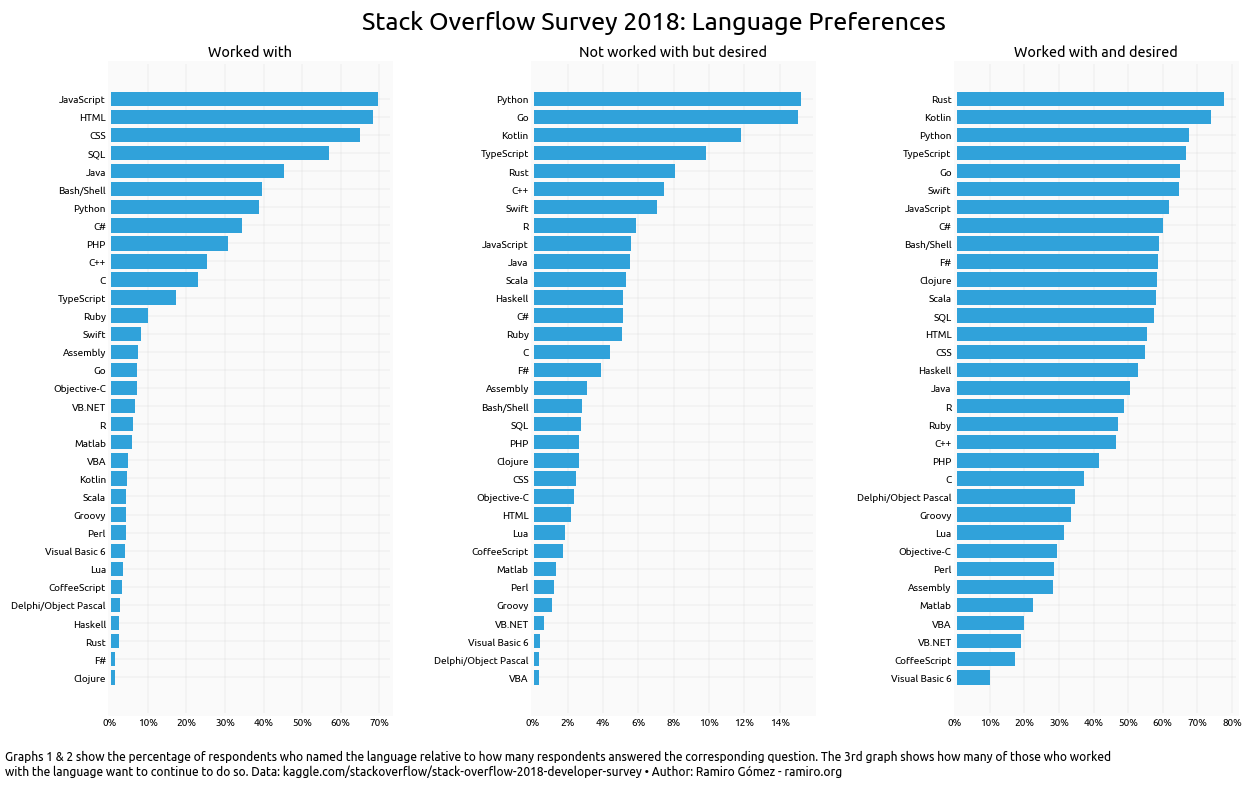

In [3]:
def plot_axis(ax, series, title):
    labels = [shorten(s, width=30, placeholder='...') for s in series.index]
    y_pos = np.arange(len(series))
    ax.barh(y_pos, series)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels, minor=False)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
        

def plot_ranking(dataframe, tech, figsize=(18, 12), min_worked_with=1000):
    columns = [f'{tech}_{col}' for col in ['worked_with', 'liked', 'new']]
    
    annotation = '''Graphs 1 & 2 show the percentage of respondents who named the {} relative to how many respondents answered the corresponding question. The 3rd graph shows how many of those who worked 
with the {} want to continue to do so. Data: kaggle.com/stackoverflow/stack-overflow-2018-developer-survey • Author: Ramiro Gómez - ramiro.org'''.format(tech, tech, tech)
    
    # Only count responses with at least one answer to the questions related to this technology
    response_count = len(dataframe[columns].replace(to_replace=set(), value=np.nan).dropna(how='all'))
        
    counters = [Counter(chain.from_iterable(dataframe[col].apply(list))) for col in columns]
    df = pd.DataFrame(counters, index=columns).T.sort_values(f'{tech}_worked_with')
    # Limit to technologies worked with by at least min_worked_with respondents
    df = df[df[f'{tech}_worked_with'] >= min_worked_with]

    worked_with = (df[f'{tech}_worked_with'] / response_count).sort_values()
    liked = (df[f'{tech}_liked'] / df[f'{tech}_worked_with']).sort_values()
    new = (df[f'{tech}_new'] / response_count).sort_values()

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    fig.suptitle('Stack Overflow Survey 2018: {} Preferences'.format(tech.title()), y=0.94, size=25)
    fig.subplots_adjust(wspace=0.5)
        
    plot_axis(axes[0], worked_with, 'Worked with')
    plot_axis(axes[1], new, 'Not worked with but desired')
    plot_axis(axes[2], liked, 'Worked with and desired')
    
    plt.annotate(annotation, xy=(5, 30), xycoords='figure pixels', size=12)


plot_ranking(df_tech, 'language')

The left graph shows the percentage of respondents who worked with a particular language relative to the number of respondents who answered the corresponding question, not the total number of respondents. As we can see languages associated with web development are most frequently used as well as SQL which is the only database query language that shows up in these rankings. The most used languages JavaScript, HTML and CSS are kind of mandatory in the web context. Even if you don't type HTML in your editor, you have to at least generate it, if you want to create a web page.

I think the middle graph is the most revealing about the reputation of languages. Python and Go seem to have the best reputation in the Stack Overflow community. They are followed by Kotlin and TypeScript whose main purpose seems to be avoiding to write code in Java and JavaScript respectively. On the lower end we see languages that either have a bad reputation or are not in vogue any more, for example CoffeeScript would probably have shown up closer to the top just a few years ago.

The graph on the right says something about how satisfying it is to work with a particular language. From my own experience I can definitely confirm that Python provides a much more joyful experience than several of the other languages that appear further towards the bottom.

Let's look at platforms next.

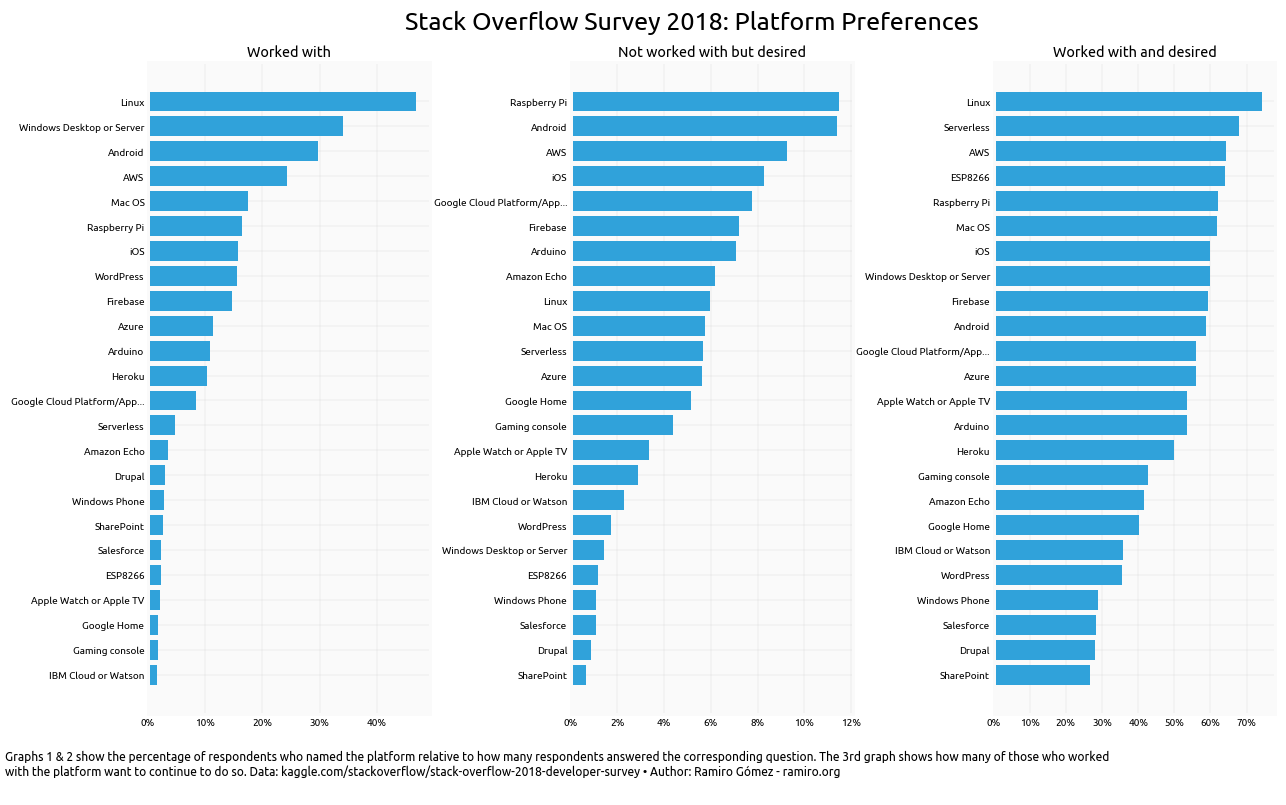

In [4]:
plot_ranking(df_tech, 'platform')

Belonging to the minority of Linux desktop users I'm happy to see that it is at least widely used in a development context and mostly liked by the people who work with it. Also it is an integral part of some of the other platforms that appear and I wonder when Microsoft will release their first Linux based operating system.

Let's look at databases now.

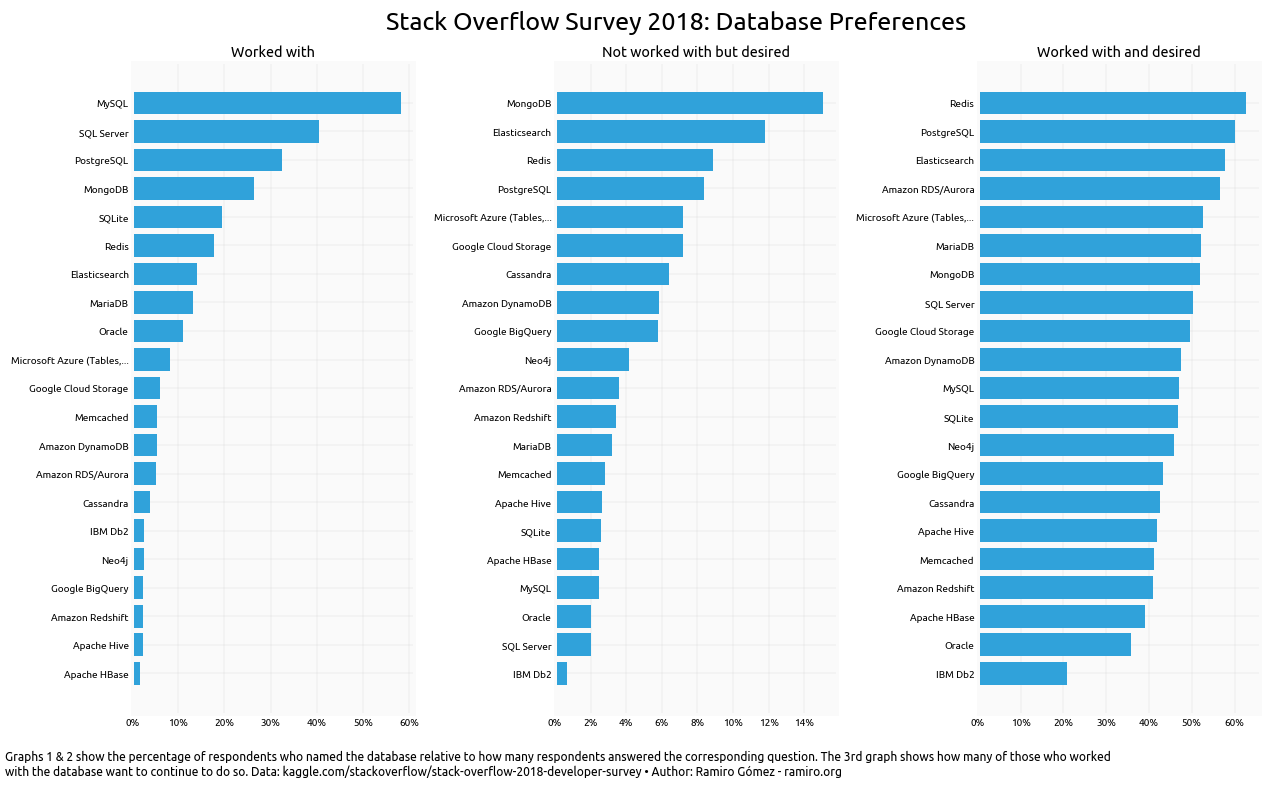

In [5]:
plot_ranking(df_tech, 'database')

I'm kind of surprised that SQLite doesn't show up higher in these rankings. Maybe it is disregarded too often when people expect to manage huge amounts of data or people don't realize that they are actually using it.

In the last plot we show frameworks mentioned by respondents.

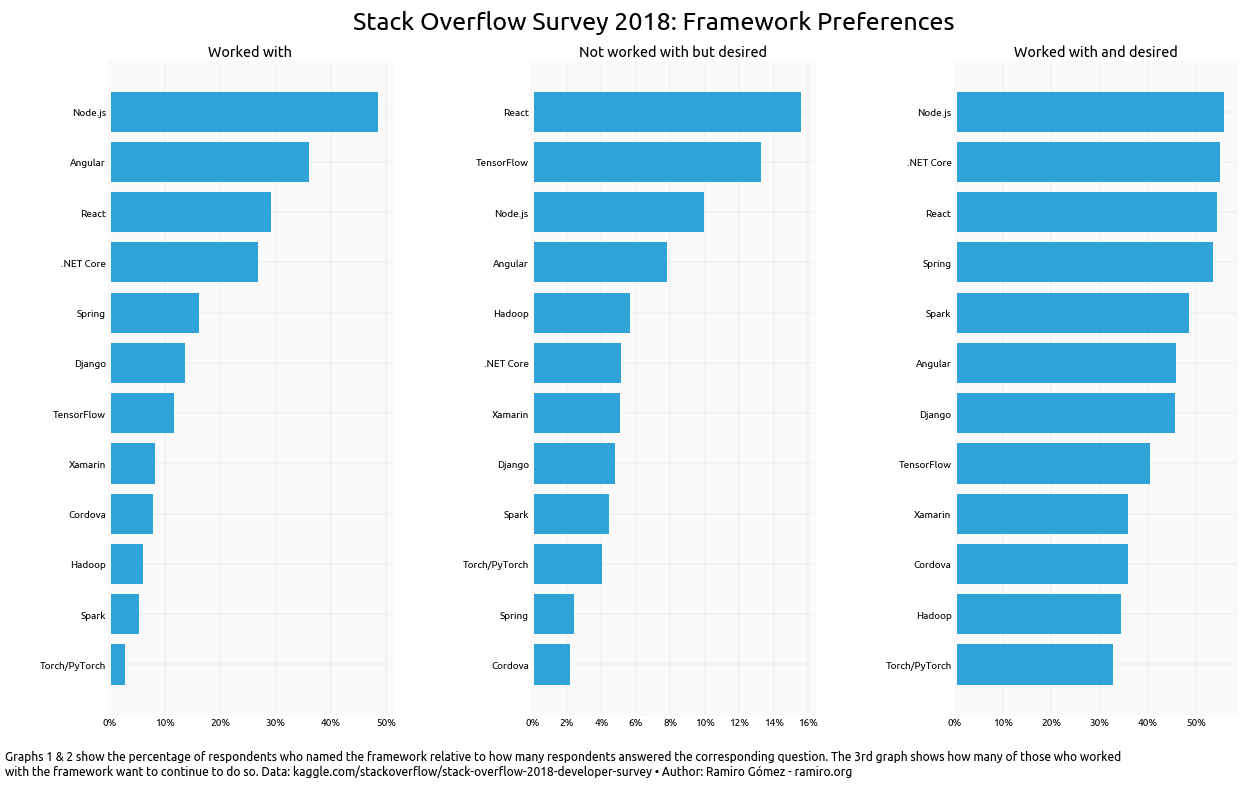

In [6]:
plot_ranking(df_tech, 'framework')

Again we can see how dominant web technologies are, although I'm not sure whether Node.js wouldn't better fit in the platform category. Looking at the 3rd graph working with frameworks generally seems to be less desirable compared to the other types of technologies. Based on my own experience frameworks often constrain you too much and the knowledge you gain through learning them doesn't transfer as well to other things compared to learning a new language for example.

## Summary

This notebook provides a peek into technology preferences of people who responded to the Stack Overflow Developer Survey 2018. It shows plots for languages, databases, platforms and frameworks that show which technologies are most widely used, which ones developers are most interested in and which are most satisfying to work with.

In [7]:
%load_ext signature
%signature